In [11]:
print("test")

test


In [12]:
import pandas as pd
from LabData.DataLoaders.GutMBLoader import GutMBLoader
from LabData.DataLoaders.SubjectLoader import SubjectLoader
from LabData.DataLoaders.DietLoggingLoader import DietLoggingLoader
from LabData.DataLoaders.LifeStyleLoader import LifeStyleLoader
from LabData.DataLoaders.BodyMeasuresLoader import BodyMeasuresLoader
# from LabData.DataAnalyses.TenK_Trajectories.utils import get_diet_logging_around_stage
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize
import seaborn as sns
import re
import pickle
import matplotlib.pyplot as plt

In [13]:
stage = 'baseline' # 'baseline' or '02_00_visit'
calc_adherence = False
david = False
show = True

In [70]:
single_style = "nature_single.mplstyle"
double_style = "nature_double.mplstyle"
third_style = "nature_third.mplstyle"
plt.rcParams["figure.dpi"] = 150
plt.style.use(single_style)
palette = sns.color_palette("Set2", n_colors=8)

In [71]:
with open('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/diet_rename_dict.pkl', 'rb') as file:
    diet_rename_dict = pickle.load(file)

In [14]:
diet_mb = pd.read_pickle('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/diet_features.pkl')
log_date = pd.read_pickle(f'/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/log_date_{stage}.pkl')
log_day = pd.read_pickle(f'/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/log_day_{stage}.pkl')
diet_category_df = pd.read_pickle(f'/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/diet_category_df_{stage}.pkl')
diet_by_person = pd.read_pickle(f'/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/diet_by_person_{stage}.pkl')

In [15]:
diet_mb.shape

(10790, 700)

In [16]:
def explore_columns(df):
    for column in df.columns:
        print(column)
        print(df[column].value_counts())

## study_ids = [10, 1001, 1002]
study_ids = [10]
subjects_dl = SubjectLoader()
subjects_data = subjects_dl.get_data(groupby_reg='first', study_ids=study_ids)
subjects_df = subjects_data.df

print(subjects_df["age"])

RegistrationCode  Date                      
10K_1000028368    2020-03-22 08:26:05.077073    54.0
10K_1000273395    2020-03-05 20:53:54.399388    41.0
10K_1000633050    2021-06-21 14:23:50.372010    66.0
10K_1000942861    2021-06-11 11:30:37.386358    54.0
10K_1001106466    2024-12-15 15:42:22.632981    59.0
                                                ... 
10K_9999226141    2019-12-04 07:07:07.815688    41.0
10K_9999409119    2020-02-22 15:19:08.365584    54.0
10K_9999623844    2023-02-19 01:46:16.838996    55.0
10K_9999732920    2022-12-23 22:20:48.083986    43.0
10K_9999767769    2020-01-31 09:11:04.104338    48.0
Name: age, Length: 27272, dtype: float64


## Load Diet Data

In [17]:
if stage == '02_00_visit':
    if not david:
        print("not david")
        with open('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/my_lists_diet.pkl', 'rb') as file:
            loaded_lists = pickle.load(file)
        base_features, all_diet_features = loaded_lists
    else:
        with open('/net/mraid20/export/genie/LabData/Analyses/tomerse/david_colab/my_lists_diet.pkl', 'rb') as file:
            loaded_lists = pickle.load(file)
        base_features, all_diet_features, check = loaded_lists


In [18]:
with open('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/food_shortnames.pkl', 'rb') as file:
    food_shortnames = pickle.load(file)
food_shortnames

Index(['Acorn squash', 'Alfalfa sprouts', 'Almond Beverage', 'Almond flour',
       'Almond spread', 'Almonds', 'Amba', 'Apple', 'Apple Cake',
       'Apple Vinegar',
       ...
       'Yellow pepper', 'Yogurt', 'Zaatar', 'Zucchini', 'Zucchini Patties',
       'black pepper', 'dried tomato spread', 'emmer wheat bread', 'ginger',
       'kale'],
      dtype='object', name='shortname_eng', length=570)

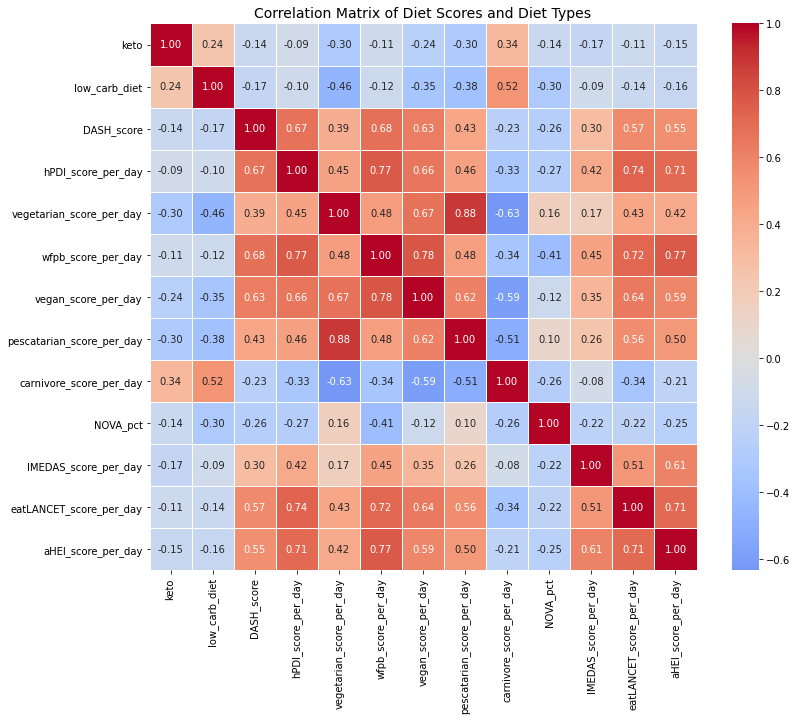

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List of column names to include
cols = [
    'keto',
    'low_carb_diet',
    'DASH_score',
    'hPDI_score_per_day',
    'vegetarian_score_per_day',
    'wfpb_score_per_day',
    'vegan_score_per_day',
    'pescatarian_score_per_day',
    'carnivore_score_per_day',
    'NOVA_pct',
    'IMEDAS_score_per_day',
    'eatLANCET_score_per_day',
    'aHEI_score_per_day'
]

# Assume df is your DataFrame
# df = pd.read_csv('your_data.csv')  # or however you load it

# Filter the dataframe to just these columns
corr_df = diet_mb[cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True, linewidths=0.5)
plt.title("Correlation Matrix of Diet Scores and Diet Types", fontsize=14)
plt.tight_layout()
plt.show()


In [20]:
# A function to view a specific RegistrationCode's diet log

def peek_at_day(log_date, registration_code, day, additional_cols=[]):
    # Filter the DataFrame for the specific RegistrationCode and Day
    filtered_log_date = log_date.loc[(registration_code, day)]

    # Select only the desired columns
    filtered_log_date = filtered_log_date[['shortname_eng', 'Energy'] + additional_cols]

    # Display the resulting DataFrame
    return filtered_log_date


def peek_at_person(log_date, registration_code, additional_cols=[]):
    pd.set_option('display.max_rows', None)
    # Filter the DataFrame for the specific RegistrationCode
    filtered_log_date = log_date.loc[registration_code]

    # Select only the desired columns
    filtered_log_date = filtered_log_date[['shortname_eng', 'Energy'] + additional_cols]

    # Display the resulting DataFrame
    return filtered_log_date

# peek_at_day(log_date, '10K_1000942861')


In [21]:
# max_registration_code = log_date.groupby(['RegistrationCode', 'Day'])['Energy'].sum().idxmax()[0]
min_registration_code = log_date.groupby(['RegistrationCode', 'Day'])['Energy'].sum().idxmin()[0]

In [22]:
# peek_at_day(log_date, max_registration_code)

In [23]:
peek_at_person(log_date, min_registration_code)

shortname_eng       Energy
Day        food_id Hour                                    
2023-07-03 1014122  11:30               Coffee     1.500000
           1008624  12:11              Almonds    88.612500
           1012601  12:11             Omelette   105.000000
           1011201  15:09              Chicken   173.160000
           1012470  15:09               Coffee    64.800000
           1014122  15:09               Coffee     1.500000
           1009182  19:40            Schnitzel   328.135000
           1013942  19:40                 Beer   215.000000
2023-07-04 1011116  09:54           Cappuccino   111.999998
           1009433  13:17            Olive oil   300.000000
           1009967  13:17   Grilled vegetables    35.100000
           1012367  13:17       Wholemeal Roll   187.016660
           1012989  13:17                  Egg    77.420000
           1009506  23:01         Chicken legs   277.346671
2023-07-05 1007529  12:17            Ice cream   271.875000
           1010971  12:17               Salmon   388.360000
           1014158  12:17              Noodles  1216.250000
           1012827  17:10            Smoothies    14.583333
           1010973  20:57           Watermelon   225.000000
           1006944  21:45              Whiskey   216.450000
           1012463  22:37                Dates   223.600000
           1013942  22:37                 Beer   215.000000
2023-07-07 1011116  11:05           Cappuccino    55.999999
           1012463  11:05                Dates   111.800000
           1010074  21:15                Pizza  1271.513947
2023-07-08 1009135  11:00            Egg Salad   152.437500
           1009238  11:00         Hummus Salad   106.200000
           1011340  11:00  Stuffed Vine leaves   168.000000
           1014376  11:00                 Beer   166.650000
           1009238  17:18         Hummus Salad    70.800000
           1010971  17:18               Salmon   776.720000
           1014376  17:18                 Beer   166.650000
2023-07-10 1007863  10:15         Orange juice   112.800000
           1009433  10:15            Olive oil   300.000000
           1012601  10:15             Omelette   217.000000
                    19:22             Omelette   217.000000
2023-07-11 1007987  08:45               Grapes   186.020000
           1013843  09:23       Sabih Sandwich  1180.790000
           1014231  18:00           Energy bar   827.000000
           1013249  22:46                 Wine   235.999992
2023-07-12 1009433  12:25            Olive oil   300.000000
           1012206  15:35     Canned Tuna Fish   170.300000
           1012989  15:35                  Egg    77.420000
           1013026  15:35              Chicken   212.300000
2023-07-13 1007294  08:30               Coffee     3.600000
           1011201  08:30              Chicken   346.320000
           1013249  08:30                 Wine   235.999992
           1013995  08:30     Avocado Sandwich   234.600000
           1011317  22:17         Jewish donut   191.400000
2023-07-14 1007294  11:20               Coffee     3.600000
           1011201  11:20              Chicken   346.320000
           1013249  11:20                 Wine   235.999992
           1013995  11:20     Avocado Sandwich   234.600000
           1008003  22:32             Potatoes   225.257141
           1009433  22:32            Olive oil    50.000000
           1010971  22:32               Salmon   776.720000
           1011201  22:32              Chicken   173.160000
2023-07-15 1009693  18:50                 Rice   381.000000
           1013427  18:50       Natural Yogurt   119.000000

In [24]:
pd.reset_option('display.max_rows')

In [25]:
log_date['MainCategoryEng'].unique()

array(['Drinks', 'Poultryanditsproducts', 'PastaGrainsandSidedishes',
       'Vegetables', 'Bread', 'MedOilandfats', 'Fruits', 'Hardcheese',
       'milkcreamcheeseandyogurts', 'sweets', 'Fishandseafood',
       'Pulsesandproducts', 'Bread_wholewheat', 'AlcoholicDrinks',
       'Beefveallambandothermeatproducts',
       'PastaGrainsandSidedishes_wholewheat', 'Eggsandtheirproducts',
       'Nutsseedsandproducts', 'FastFoods', 'Deepfriedfoods',
       'fruitjuicesandsoftdrinks', 'sweetmilkproducts', 'Soupsandsauces',
       'Oilsandfats', 'Cannedvegandfruits',
       'Industrializedvegetarianfoodreadytoeat', 'bakedgoods', 'Cereals',
       'Proccessedmeatproducts', 'Lowcaloriesanddietdrinks',
       'Spicesandherbs', 'Snacks', 'Others', nan], dtype=object)

In [26]:
def foods_in_category(category):
    print(log_date[log_date['MainCategoryEng'] == category]['shortname_eng'].unique())

foods_in_category('fruitjuicesandsoftdrinks')
foods_in_category('MedOilandfats')
foods_in_category('Oilsandfats')
# foods_in_category('PastaGrainsandSidedishes_wholewheat')
# foods_in_category('Bread_wholewheat')
# foods_in_category('Eggsandtheirproducts')
# foods_in_category('milkcreamcheeseandyogurts')
# foods_in_category('Hardcheese')

['Pomegranate juice' 'Orange juice' 'Carrot Juice' 'Lemon juice' 'Coke'
 'Lemonade' 'Smoothies' 'Apple juice' 'Diet Coke' 'Sweetened Cocoa Powder'
 'Flavored Waters' 'Fruit Drink' 'Cocktail' 'Grapefruit juice'
 'Malt beverage' 'Coffee' 'Tea']
['Tahini' 'Avocado' 'Olives' 'Guacamole' 'Olive oil' 'Oil']
['Olive oil' 'Cooking cream' 'Heavy cream' 'Butter' 'Coconut water'
 'Whipped cream' 'Coconut Oil']


In [27]:
# Creating a dataframe with category and corresponding list of foods
category_foods_df = log_date.groupby('MainCategoryEng')['shortname_eng'].unique().reset_index()
category_foods_df.rename(columns={'shortname_eng': 'Foods'}, inplace=True)
# category_foods_df.to_csv("/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/category_foods.csv", index=False)
category_foods_df

,MainCategoryEng,Foods
0,AlcoholicDrinks,"[Wine, Beer, Whiskey, Campari, Vodka or Arak, ..."
1,Beefveallambandothermeatproducts,"[Beef, Kebab, Meatballs, Pork, Turkey Shawarma..."
2,Bread,"[Pita, Bread, Baguette, Pizza, Wholemeal Bread..."
3,Bread_wholewheat,"[Rye Bread, Wholemeal Roll, Rice crackers, Who..."
4,Cannedvegandfruits,"[Pickled cucumber, Prune, Apricot, Dates, Oliv..."
5,Cereals,"[Cereals, Pecans, Granola, Granola bar, Pita]"
6,Deepfriedfoods,"[Sweet Potato Fries, French fries, Jewish donut]"
7,Drinks,"[Coffee, Cappuccino, Green Tea, Tea, Coconut w..."
8,Eggsandtheirproducts,"[Omelette, Egg, Shakshouka, Egg Salad, Egg San..."
9,FastFoods,"[Onion Rings, Hamburger, Pizza, French fries, ..."


Get feature to categories mapping for SHAP feature aggregation downstream

In [28]:
# # Cleaned category labels
# cleaned_category_labels = {
#     'MedOilandfats': 'Mediterranean Oils & Fats',
#     'Soupsandsauces': 'Soups & Sauces',
#     'Proccessedmeatproducts': 'Processed Meat Products',
#     'PastaGrainsandSidedishes': 'Pasta, Grains & Side Dishes',
#     'milkcreamcheeseandyogurts': 'Dairy Products',
#     'Fishandseafood': 'Fish & Seafood',
#     'Eggsandtheirproducts': 'Eggs & Their Products',
#     'PastaGrainsandSidedishes_wholewheat': 'Whole Grain Pasta & Sides',
#     'Fruits': 'Fruits',
#     'Industrializedvegetarianfoodreadytoeat': 'Processed Vegeterian Foods',
#     'sweetmilkproducts': 'Sweet Dairy Products',
#     'Others': 'Miscellaneous',
#     'AlcoholicDrinks': 'Alcoholic Beverages',
#     'Oilsandfats': 'Oils & Fats',
#     'Bread_wholewheat': 'Whole Wheat Bread',
#     'FastFoods': 'Fast Food',
#     'Pulsesandproducts': 'Legumes & Pulses',
#     'Nutsseedsandproducts': 'Nuts & Seeds',
#     'Cereals': 'Cereals',
#     'Hardcheese': 'Hard Cheeses',
#     'Snacks': 'Snacks',
#     'Deepfriedfoods': 'Deep-Fried Foods',
#     'Poultryanditsproducts': 'Poultry',
#     'Drinks': 'Beverages',
#     'Cannedvegandfruits': 'Canned Vegetables & Fruits',
#     'Vegetables': 'Vegetables',
#     'fruitjuicesandsoftdrinks': 'Juices & Soft Drinks',
#     'bakedgoods': 'Baked Goods',
#     'Beefveallambandothermeatproducts': 'Beef, Veal & Lamb',
#     'Spicesandherbs': 'Spices & Herbs',
#     'Bread': 'Bread',
#     'sweets': 'Sweets'
# }

# # Apply mapping to the dataframe
# category_foods_df["CleanedCategory"] = category_foods_df["MainCategoryEng"].map(
#     lambda x: cleaned_category_labels.get(x, x)  # Defaults to original name if not in mapping
# )

# Convert feature-category mapping into a dictionary
feature_to_category = {}
for _, row in category_foods_df.iterrows():
    category = row["MainCategoryEng"]
    for food in row["Foods"]:  # Iterate over the list of foods
        cleaned_food_name = re.sub(r'[^a-zA-Z0-9_]', '_', food)  # Standardize feature name
        feature_to_category[cleaned_food_name] = category

# Get unique categories (for reference)
categories = list(set(feature_to_category.values()))

# Define file path for pickling
pickle_file = '/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/food_categories.pkl'

# Save the tuple containing both objects
with open(pickle_file, "wb") as f:
    pickle.dump((feature_to_category, categories), f)

print("Feature-to-category mapping saved with cleaned labels!")

Feature-to-category mapping saved with cleaned labels!


In [29]:
feature_to_category

{'Wine': 'AlcoholicDrinks',
 'Beer': 'AlcoholicDrinks',
 'Whiskey': 'AlcoholicDrinks',
 'Campari': 'AlcoholicDrinks',
 'Vodka_or_Arak': 'AlcoholicDrinks',
 'Sweet_wine': 'AlcoholicDrinks',
 'Dessert_Wine': 'AlcoholicDrinks',
 'Light_Beer': 'AlcoholicDrinks',
 'Ouzo': 'AlcoholicDrinks',
 'Gin_and_tonic': 'AlcoholicDrinks',
 'Fruit_Drink': 'fruitjuicesandsoftdrinks',
 'Cocktail': 'fruitjuicesandsoftdrinks',
 'Beef': 'Beefveallambandothermeatproducts',
 'Kebab': 'Beefveallambandothermeatproducts',
 'Meatballs': 'Proccessedmeatproducts',
 'Pork': 'Proccessedmeatproducts',
 'Turkey_Shawarma': 'Poultryanditsproducts',
 'Steak': 'Beefveallambandothermeatproducts',
 'Chopped_Liver': 'Beefveallambandothermeatproducts',
 'Beef_Cholent': 'Beefveallambandothermeatproducts',
 'Bolognese': 'Beefveallambandothermeatproducts',
 'Lamb_Kebabs': 'Beefveallambandothermeatproducts',
 'Veal_kebabs': 'Beefveallambandothermeatproducts',
 'Hamburger': 'Proccessedmeatproducts',
 'Mutton': 'Proccessedmeatproduct

In [30]:
diet_foods_df = pd.read_csv('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/diet_adherence_foods.csv', index_col=0)
diet_foods_df.head()

,Chocolate Cookies,Honey,Cappuccino,Cottage cheese,Tomatoes,Oatmeal Cereal,Apple,Banana,Peach,Rye Bread,...,Cocktail,Soybean oil,Dried celery,Harissa salad,Sangria,Beet Juice,Dried banana,Salmon Sandwich,Semi soft Cheese,Gum
Mediterranean,0,1,1,1,1,1,1,1,1,0,...,0,0,1,0,0,1,0,0,0,0
Paleo,0,1,0,0,1,0,1,1,1,0,...,0,0,1,0,0,1,0,0,0,0
WFPB,0,0,0,0,1,1,1,1,1,0,...,0,0,1,0,0,1,0,0,0,0
Vegan,0,0,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,0,1
Vegetarian,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,1


In [31]:
# diet_foods_df = diet_foods_df.loc[:,diet_foods_df.columns.isin(log_date['shortname_eng'].unique())]
diet_foods_df = diet_foods_df.loc[:,diet_foods_df.columns.isin(food_shortnames)]
diet_foods_df

,Chocolate Cookies,Honey,Cappuccino,Cottage cheese,Tomatoes,Oatmeal Cereal,Apple,Banana,Peach,Rye Bread,...,Coated Biscuits,Avocado Sandwich,Pickled Chili pepper,Kif Kef,Egg Roll,Mekupelet,Apropo,Sweet Potato Pie,Cocktail,Salmon Sandwich
Mediterranean,0,1,1,1,1,1,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
Paleo,0,1,0,0,1,0,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
WFPB,0,0,0,0,1,1,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
Vegan,0,0,0,0,1,1,1,1,1,1,...,0,1,1,0,0,0,1,1,1,0
Vegetarian,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
Pescatarian,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Carnivore,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NOVA,4,2,3,3,1,3,1,1,1,4,...,4,4,3,4,3,4,4,3,3,4
Tubers,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Pork,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# # # Add NOVA scores
# # Step 1: Calculate the mean Score for each food (shortname_eng)
# mean_scores = log_date.groupby('shortname_eng')['Score'].mean()

# # Step 2: Create a dictionary mapping shortname_eng to its mean Score
# score_dict = mean_scores.round().astype('Int64').to_dict()

# # Step 3: Prepare the new row with mean Scores for each food column in diet_foods_df
# new_row = {col: score_dict.get(col, None) for col in diet_foods_df.columns}

# # Step 4: Add the new row labeled as "NOVA"
# diet_foods_df.loc["NOVA"] = pd.Series(new_row)



In [33]:
# diet_foods_df

## Observe Diets

In [34]:
observe_diets = log_day[['vegetarian_score_per_day', 'wfpb_score_per_day', 'vegan_score_per_day', 'carnivore_score_per_day', 'Energy', 'pct_carb_calories', 'pct_protein_calories', 'pct_fat_calories', 'Foods_per_meal', 'Foods_per_day', 'Meals_per_day', 'plant_foods_per_day', 'plant_foods_per_week', 'Carbohydrate, by difference', 'Protein', 'Total lipid (fat)']]
observe_diets

vegetarian_score_per_day  wfpb_score_per_day  \
RegistrationCode Day                                                        
10K_1000942861   2021-12-13                  0.850351            0.464833   
                 2021-12-14                  0.660752            0.369795   
                 2021-12-15                  0.823081            0.000000   
                 2021-12-16                  0.737683            0.000000   
                 2021-12-17                  0.486256            0.000000   
...                                               ...                 ...   
10K_9999409119   2020-06-18                  1.000000            0.420629   
                 2020-06-19                  1.000000            0.811087   
                 2020-06-20                  1.000000            0.558395   
                 2020-06-21                  1.000000            0.166613   
                 2020-06-22                  1.000000            0.533672   

                             vegan_score_per_day  carnivore_score_per_day  \
RegistrationCode Day                                                        
10K_1000942861   2021-12-13             0.799347                 0.051004   
                 2021-12-14             0.604812                 0.339248   
                 2021-12-15             0.566358                 0.176919   
                 2021-12-16             0.152936                 0.000000   
                 2021-12-17             0.343063                 0.372523   
...                                          ...                      ...   
10K_9999409119   2020-06-18             1.000000                 0.000000   
                 2020-06-19             0.816849                 0.000000   
                 2020-06-20             0.882229                 0.000000   
                 2020-06-21             0.648202                 0.000000   
                 2020-06-22             1.000000                 0.000000   

                                  Energy  pct_carb_calories  \
RegistrationCode Day                                          
10K_1000942861   2021-12-13  2320.424974          46.471634   
                 2021-12-14  1407.229165          44.775858   
                 2021-12-15  1548.049988          40.784484   
                 2021-12-16  1773.616661          49.852186   
                 2021-12-17  2458.909988          27.185379   
...                                  ...                ...   
10K_9999409119   2020-06-18   910.237320          67.958487   
                 2020-06-19  1419.590000          41.625117   
                 2020-06-20  1434.397500          37.559937   
                 2020-06-21  2164.896633          58.184328   
                 2020-06-22   761.235001          57.479413   

                             pct_protein_calories  pct_fat_calories  \
RegistrationCode Day                                                  
10K_1000942861   2021-12-13             16.682134         39.377136   
                 2021-12-14             21.750887         34.147972   
                 2021-12-15             17.641162         42.108408   
                 2021-12-16             16.351824         29.326264   
                 2021-12-17             26.812206         46.300674   
...                                           ...               ...   
10K_9999409119   2020-06-18             11.546723         25.704279   
                 2020-06-19             16.289056         47.806054   
                 2020-06-20             10.952459         46.412385   
                 2020-06-21             10.768724         33.590449   
                 2020-06-22             10.747667         37.083687   

                             Foods_per_meal  Foods_per_day  Meals_per_day  \
RegistrationCode Day                                                        
10K_1000942861   2021-12-13        2.000000             12              6   
                 2021-12-14        2.000000       

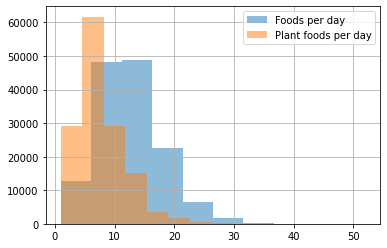

In [35]:
if show:
    observe_diets['Foods_per_day'].hist(alpha=0.5, label='Foods per day')
    observe_diets['plant_foods_per_day'].hist(alpha=0.5, label='Plant foods per day')
    plt.legend()
    plt.show()

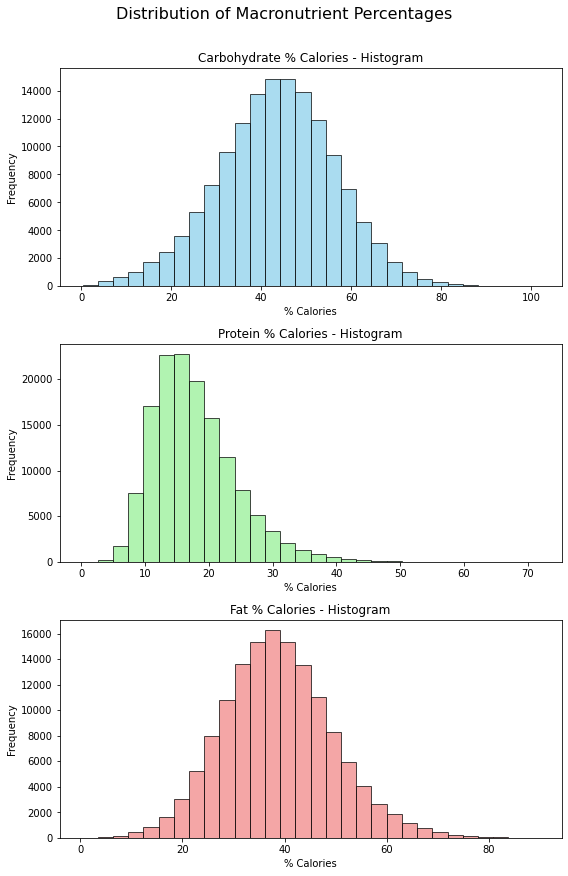

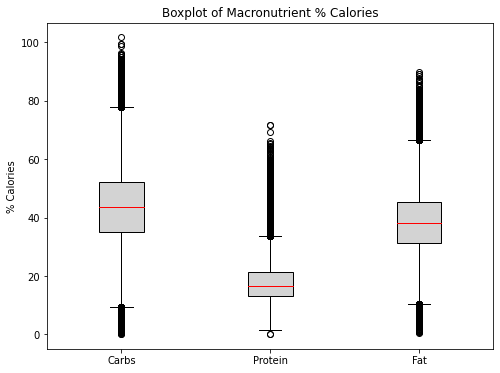

In [36]:
if show:  
    fig, axes = plt.subplots(3, 1, figsize=(8, 12))
    fig.suptitle('Distribution of Macronutrient Percentages', fontsize=16, y=1.01)

    # Histograms for each macro
    axes[0].hist(observe_diets['pct_carb_calories'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0].set_title('Carbohydrate % Calories - Histogram')
    axes[0].set_xlabel('% Calories')
    axes[0].set_ylabel('Frequency')

    axes[1].hist(observe_diets['pct_protein_calories'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1].set_title('Protein % Calories - Histogram')
    axes[1].set_xlabel('% Calories')
    axes[1].set_ylabel('Frequency')

    axes[2].hist(observe_diets['pct_fat_calories'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[2].set_title('Fat % Calories - Histogram')
    axes[2].set_xlabel('% Calories')
    axes[2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Boxplot
    plt.figure(figsize=(8, 6))
    plt.boxplot([observe_diets['pct_carb_calories'], observe_diets['pct_protein_calories'], observe_diets['pct_fat_calories']], 
                labels=['Carbs', 'Protein', 'Fat'], patch_artist=True, 
                boxprops=dict(facecolor='lightgrey'), medianprops=dict(color='red'))
    plt.title('Boxplot of Macronutrient % Calories')
    plt.ylabel('% Calories')
    plt.show()



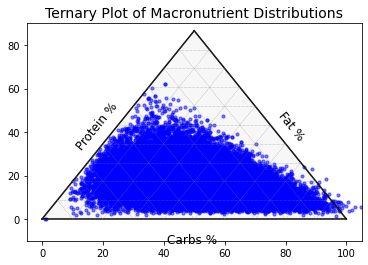

In [37]:
if show:
    import ternary

    # Prepare data for the ternary plot
    points = list(zip(observe_diets['pct_carb_calories'], observe_diets['pct_protein_calories'], observe_diets['pct_fat_calories']))

    # Set up the ternary plot
    figure, tax = ternary.figure(scale=100)
    tax.scatter(points, marker='o', color='blue', s=10, alpha=0.5)

    # Add labels and styling
    tax.boundary()
    tax.gridlines(multiple=10, color="gray", linewidth=0.5)
    tax.left_axis_label("Protein %", fontsize=12)
    tax.right_axis_label("Fat %", fontsize=12)
    tax.bottom_axis_label("Carbs %", fontsize=12)
    tax.set_title("Ternary Plot of Macronutrient Distributions", fontsize=14)

    # Show the plot
    plt.show()

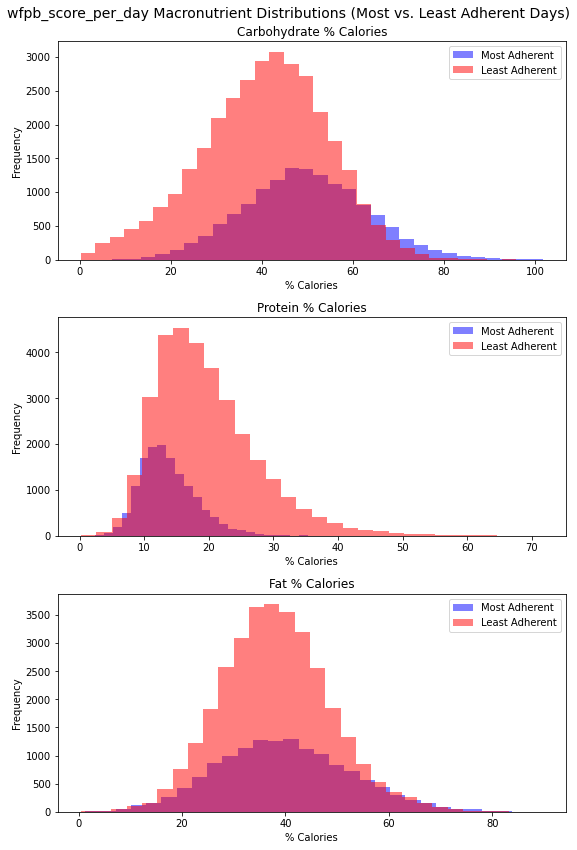

In [38]:
if show:
    # Update adherence thresholds
    diet_score_col = 'wfpb_score_per_day'

    threshold_high = observe_diets[diet_score_col].quantile(0.9)
    threshold_low = observe_diets[diet_score_col].quantile(0.1)

    most_adherent = observe_diets[observe_diets[diet_score_col] >= threshold_high]
    least_adherent = observe_diets[observe_diets[diet_score_col] <= threshold_low]

    # Overlay histograms for most and least adherent days
    fig, axes = plt.subplots(3, 1, figsize=(8, 12))
    fig.suptitle(f'{diet_score_col} Macronutrient Distributions (Most vs. Least Adherent Days)', fontsize=14)

    # Carbs
    axes[0].hist(most_adherent['pct_carb_calories'], bins=30, alpha=0.5, color='blue', edgecolor='none', label='Most Adherent')
    axes[0].hist(least_adherent['pct_carb_calories'], bins=30, alpha=0.5, color='red', edgecolor='none', label='Least Adherent')
    axes[0].set_title('Carbohydrate % Calories')
    axes[0].set_xlabel('% Calories')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()

    # Proteins
    axes[1].hist(most_adherent['pct_protein_calories'], bins=30, alpha=0.5, color='blue', edgecolor='none', label='Most Adherent')
    axes[1].hist(least_adherent['pct_protein_calories'], bins=30, alpha=0.5, color='red', edgecolor='none', label='Least Adherent')
    axes[1].set_title('Protein % Calories')
    axes[1].set_xlabel('% Calories')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()

    # Fats
    axes[2].hist(most_adherent['pct_fat_calories'], bins=30, alpha=0.5, color='blue', edgecolor='none', label='Most Adherent')
    axes[2].hist(least_adherent['pct_fat_calories'], bins=30, alpha=0.5, color='red', edgecolor='none', label='Least Adherent')
    axes[2].set_title('Fat % Calories')
    axes[2].set_xlabel('% Calories')
    axes[2].set_ylabel('Frequency')
    axes[2].legend()

    plt.tight_layout()
    plt.show()


In [39]:
# observe_diets[(observe_diets['med_score_per_day'] > 0) & (observe_diets['med_score_per_day'] < 0.5)]
if show:
    observe_diets[(observe_diets['carnivore_score_per_day'] == 0)]

In [40]:
# peek_at_day(log_date, '10K_1000942861', '2021-12-13', ['Carbohydrate, by difference', 'Protein', 'Total lipid (fat)'])

In [41]:
# Reset after using peek_at_day
pd.reset_option('display.max_rows')

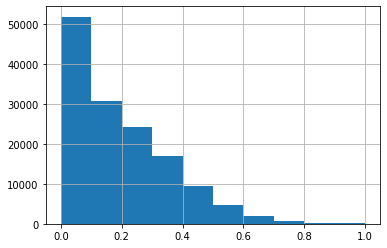

In [42]:
if show:
    observe_diets['carnivore_score_per_day'].hist()

In [43]:
if show:    
    # log_date[log_date['Carbohydrate, by difference'] == 0][['shortname_eng', 'Sugars, Total']]
    print("Foods with 0 carbs:")
    print(log_date[log_date['Carbohydrate, by difference'] == 0]['shortname_eng'].unique())
    print("Foods with 0 protein:")
    print(log_date[log_date['Protein'] == 0]['shortname_eng'].unique())
    print("Foods with 0 fat:")
    print(log_date[log_date['Total lipid (fat)'] == 0]['shortname_eng'].unique())

Foods with 0 carbs:
['Coffee' 'Green Tea' 'Beef' 'Tea' 'Pullet' 'Olive oil' 'Salmon'
 'Chicken Steak' 'Gilthead Bream' 'Steak' 'Canned Tuna Fish' 'Lamb Kebabs'
 'Turkey Shawarma' 'Vodka or Arak' 'Sushi' 'Mutton' 'Halloumi Cheese'
 'Minced meat' 'Roast beef' 'Seabass Fish' 'Carpaccio' 'Canned Sardine'
 'Meagre Fish' 'Pork' 'Hamburger' 'Gin and tonic' 'Chicken' 'Butter' 'Oil'
 'Tuna Salad' 'Sugar substitute']
Foods with 0 protein:
['Green Tea' 'Tea' 'Olive oil' 'Vinaigrette' 'Lemonade' 'Maple syrup'
 'Whiskey' 'Sugar' 'Vodka or Arak' 'Candies' 'Jam' 'Popsicle' 'Date honey'
 'Gin and tonic' 'Wafers' 'Fruit Drink' 'Sugar substitute' 'Maple Cake'
 'Oil' 'Flavored Waters' 'Coconut Oil']
Foods with 0 fat:
['Green Tea' 'Wine' 'Honey' 'Tea' 'Beer' 'Date honey' 'Whiskey'
 'Brown Sugar' 'Sugar' 'Vodka or Arak' 'Sweet wine' 'Dessert Wine'
 'Light Beer' 'Balsamic vinegar' 'Ouzo' 'Sugar substitute'
 'Flavored Waters' 'Gin and tonic' 'Fruit Drink' 'Lemonade' 'Popsicle'
 'Artichoke' 'Mixed Vegetables'

In [44]:
# peek_at_day(log_date, '10K_1515664253', ['weight'])

In [45]:
pd.reset_option('display.max_rows')

In [46]:
if show:
    # Define the lists of foods
    foods_with_0_carbs = list(log_date[log_date['Carbohydrate, by difference'] == 0]['shortname_eng'].unique())
    foods_with_0_protein = list(log_date[log_date['Protein'] == 0]['shortname_eng'].unique())
    foods_with_0_fat = list(log_date[log_date['Total lipid (fat)'] == 0]['shortname_eng'].unique())

    # Filter the DataFrame for rows that match foods from the lists
    foods_combined = set(foods_with_0_carbs + foods_with_0_protein + foods_with_0_fat)
    # log_date[log_date['shortname_eng'].isin(foods_combined)]
    pd.set_option('display.max_columns', None)
    log_date[(log_date['weight'] > 2000) & (log_date['weight'] < 4000)][['weight', 'Energy', 'shortname_eng', 'MainCategoryEng']]



In [47]:
pd.reset_option('display.max_rows')

In [48]:
# # Calorie distribution to choose threshold
# # Calculate the 99th percentile for 'Energy'
# percentile_99 = log_date['Energy'].quantile(0.99)

# # Plot the histogram
# plt.figure(figsize=(10, 6))
# log_date['Energy'].hist(bins=30, edgecolor='black')
# plt.axvline(percentile_99, color='red', linestyle='--', label=f'99th Percentile: {percentile_99:.2f}')
# plt.title('Histogram of Energy')
# plt.xlabel('Energy')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()

In [49]:
log_date['weight'].min()

0.0

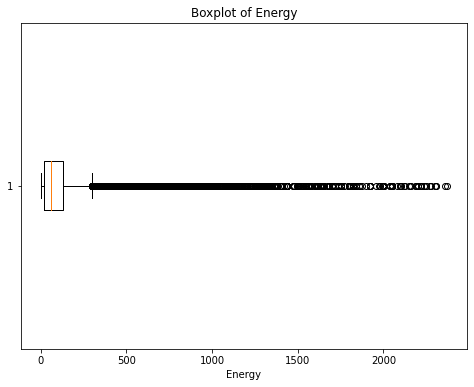

In [50]:
if show:
    plt.figure(figsize=(8, 6))
    plt.boxplot(log_date['weight'].dropna(), vert=False)
    plt.title('Boxplot of Energy')
    plt.xlabel('Energy')
    plt.show()

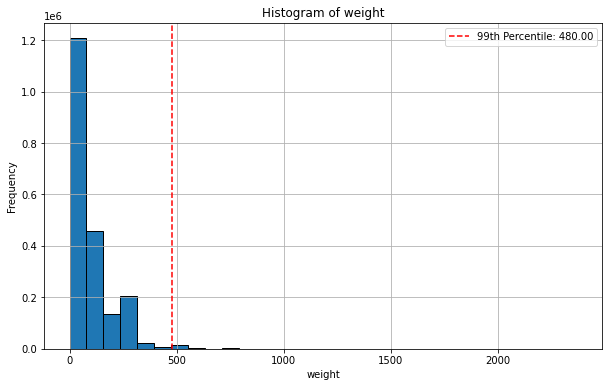

In [51]:
if show:
    # Calorie distribution to choose threshold
    # Calculate the 99th percentile for 'Energy'
    percentile_99 = log_date['weight'].quantile(0.99)

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    log_date['weight'].hist(bins=30, edgecolor='black')
    plt.axvline(percentile_99, color='red', linestyle='--', label=f'99th Percentile: {percentile_99:.2f}')
    plt.title('Histogram of weight')
    plt.xlabel('weight')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [52]:
if show:
    log_date[log_date['Energy'] > 2500][['weight', 'Energy', 'shortname_eng']]

## Variance Features

In [53]:
# # log_grouped = log_day.reset_index().groupby(['RegistrationCode']).mean()
# log_grouped = log_day.reset_index().drop("Day", axis=1).groupby(['RegistrationCode']).mean()
# log_grouped

In [54]:
diet_categories = diet_category_df.columns
diet_categories

Index(['AlcoholicDrinks', 'Beefveallambandothermeatproducts', 'Bread',
       'Bread_wholewheat', 'Cannedvegandfruits', 'Cereals', 'Deepfriedfoods',
       'Drinks', 'Eggsandtheirproducts', 'FastFoods', 'Fishandseafood',
       'Fruits', 'Hardcheese', 'Industrializedvegetarianfoodreadytoeat',
       'Lowcaloriesanddietdrinks', 'MedOilandfats', 'Nutsseedsandproducts',
       'Oilsandfats', 'Others', 'PastaGrainsandSidedishes',
       'PastaGrainsandSidedishes_wholewheat', 'Poultryanditsproducts',
       'Proccessedmeatproducts', 'Pulsesandproducts', 'Snacks',
       'Soupsandsauces', 'Spicesandherbs', 'Vegetables', 'bakedgoods',
       'fruitjuicesandsoftdrinks', 'milkcreamcheeseandyogurts',
       'sweetmilkproducts', 'sweets'],
      dtype='object', name='MainCategoryEng')

In [55]:
category_sex_df = diet_category_df.join(subjects_df[["age", "gender"]])
category_sex_df = category_sex_df.reset_index(level=[1], drop=True)
category_sex_df = category_sex_df.dropna()
category_sex_df

# Initialize an empty list to store the results
results = []

# Loop through each category
for category in diet_categories:
    # Filter data for males and females
    male_category = category_sex_df[category_sex_df['gender'] == 1][category]
    female_category = category_sex_df[category_sex_df['gender'] == 0][category]

    # Calculate the median for each gender
    male_median = male_category.median()
    female_median = female_category.median()

    # Append the results to the list
    results.append({'Category': category, 'Male Median': male_median, 'Female Median': female_median})

# Convert the results list to a DataFrame
median_df = pd.DataFrame(results)

# Display the DataFrame
print(median_df)

                                  Category  Male Median  Female Median
0                          AlcoholicDrinks     0.010772       0.001454
1         Beefveallambandothermeatproducts     0.037231       0.018758
2                                    Bread     0.110446       0.093515
3                         Bread_wholewheat     0.011766       0.015974
4                       Cannedvegandfruits     0.000925       0.001478
5                                  Cereals     0.000000       0.000000
6                           Deepfriedfoods     0.000000       0.000000
7                                   Drinks     0.007839       0.012370
8                     Eggsandtheirproducts     0.026868       0.032344
9                                FastFoods     0.000000       0.000000
10                          Fishandseafood     0.023229       0.025178
11                                  Fruits     0.045328       0.057752
12                              Hardcheese     0.015455       0.020556
13  In

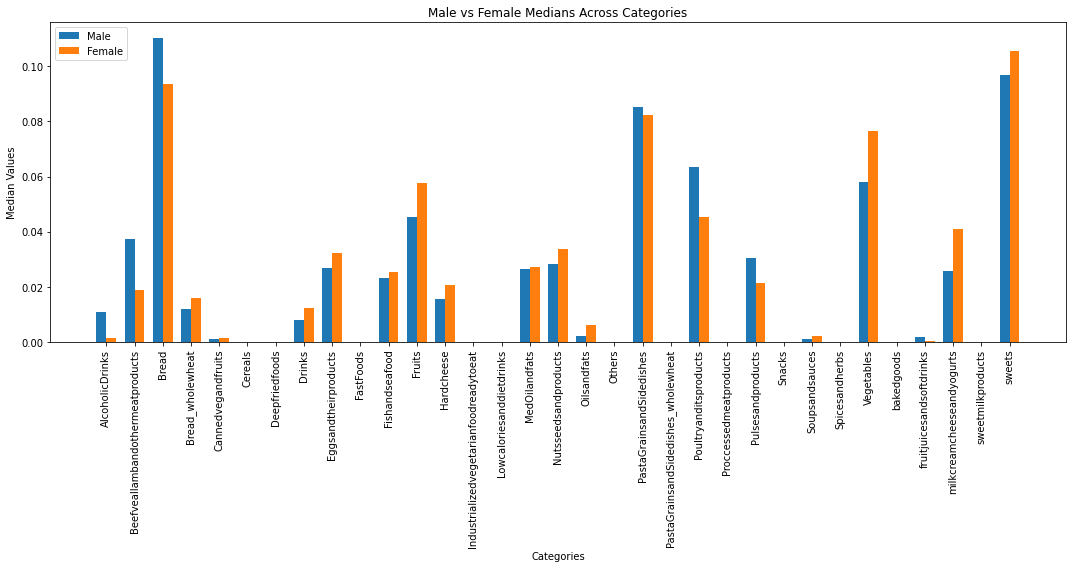

In [56]:
# Visualization
# Set positions and width for bars
x = np.arange(len(median_df['Category']))  # Label locations
width = 0.35  # Width of the bars

# Create the bar plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plotting the bars
bar1 = ax.bar(x - width/2, median_df['Male Median'], width, label='Male')
bar2 = ax.bar(x + width/2, median_df['Female Median'], width, label='Female')

# Add labels, title, and legend
ax.set_xlabel('Categories')
ax.set_ylabel('Median Values')
ax.set_title('Male vs Female Medians Across Categories')
ax.set_xticks(x)
ax.set_xticklabels(median_df['Category'], rotation=90)
ax.legend()

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()

In [57]:
# Reset after using peek_at_day
pd.reset_option('display.max_rows')

In [58]:
diet_mb

,Acorn squash,Alfalfa sprouts,Almond Beverage,Almond flour,Almond spread,Almonds,Amba,Apple,Apple Cake,Apple Vinegar,Apple juice,Apricot,Apropo,Artichoke,Arugula,Asparagus,Avocado,Avocado Sandwich,Bagel,Baguette,Baked apple,Baklava,Balsamic vinegar,Bamba,Banana,Banana Cake,Barbecue sauce,Barley soup,Basil,Bean Noodles,Bean soup,Beans,Beans black-eyed peas,Beef,Beef Cholent,Beef Lasagna,Beef Shawarma,Beer,Beet,Beet Salad,Berries,Biscuit,Bissli,Black beans,Blintzes,Blue Cheese,Blueberries,Boiled corn,Bolognese,Bounty,Brazil nuts,Bread,Bread Crumbs,Brioche,Broccoli,Broth,Brown Rice,Brown Sugar,Brownies,Buckwheat Bread,Buckwheat crackers,Bulgur,Burekas,Butter,Butter Cookies,Caesar Salad,Cake,Calamari,Camembert or Brie,Campari,Candies,Canned Sardine,Canned Tuna Fish,Canned corn,Cappuccino,Carpaccio,Carrot Cake,Carrot Juice,Carrot Salad,Carrots,Cashew,Cauliflower,Cauliflower Patties,Cauliflower Pie,Celery,Cereal Bar,Cereals,Ceviche,Challah,Chard,Cheddar,Cheese Pastry,Cheese Pie,Cheesecake,Cherries,Cherry tomatoes,Chestnuts,Chia seeds,Chicken,Chicken Liver,Chicken Meatballs,Chicken Pad Thai,Chicken Shawarma,Chicken Steak,Chicken breast,Chicken drumstick,Chicken legs,Chicken soup,Chicken wings,Chili pepper,Chili sauce,Chilli Con Carne,Chocolate,Chocolate Cookies,Chocolate Mousse,Chocolate balls,Chocolate cake,Chocolate spread,Chopped Liver,Ciabatta,Cinnamon,Cinnamon Danish,Coated Biscuits,Coated Wafers,Coated peanuts,Cocktail,Coconut,Coconut Oil,Coconut milk,Coconut water,Coffee,Coke,Cold cut,Coleslaw,Cooked Okra,Cooked Pumpkin,Cooked Sweet potato,Cooked broccoli,Cooked cabbage,Cooked green beans,Cooked tomatoes,Cooked vegetables,Cooked zucchini,Cookies,Cookies Oreo,Cooking cream,Coriander,Corn,Corn Soup,Corn casserole,Corn crackers,Corn schnitzel,Cottage cheese,Couscous,Cracker,Crackers,Cranberries,Cream Cake,Cream Cheese,Creme Brulee,Croissant,Croutons,Crushed tomatoes,Cuba,Cucumber,Curry Paste,Danish,Dark Chocolate,Date honey,Dates,Dessert Wine,Diet Cheesecake,Diet Coke,Dill,Doritos,Dried Fruit,Dried Herring,Dried Mango,Dried apple,Dried cranberries,Dried fig,Dried pineapple,Edamame,Eel,Egg,Egg Roll,Egg Salad,Egg Sandwich,Egg noodles,Egg yolk,Eggplant,Eggplant Salad,Emmental cheese,Empanadas,Energy bar,English cake,Entrecote,Eshel,Falafel,Fava beans,Fennel,Fennel Salad,Feta Cheese,Fig,Fish Roe Salad,Fish balls,Fish schnitzel,Flavored Waters,Flavored Yogurt,Flax seeds,French fries,Fried Bread,Fried Sweet potato,Fried cauliflower,Fried eggplant,Fried onions,Fruit Drink,Fruit flavored Yogurt,Fruit juice,Fruit salad,Garlic,Gefilte fish,Gilthead Bream,Gin and tonic,Gluten free bread,Gnocchi,Goat Cheese,Goat Milk Yogurt,Goji berry,Gouda Cheese,Granola,Granola Cookies,Granola bar,Grapefruit,Grapefruit juice,Grapes,Greek Yogurt,Greek salad,Green Salad,Green Tea,Green beans,Green cabbage,Green onions,Green pepper,Grilled vegetables,Grits,Guacamole,Guava,Gumdrops,Halloumi Cheese,Halva,Hamantaschen,Hamburger,Hazelnuts,Heavy cream,Herring,Honey,Honey Cake,Hummus,Hummus Salad,Ice cream,Ice cream bar,Israeli couscous,Jachnun,Jam,Jerusalem mixed grill,Jewish donut,Kashkaval,Kebab,Ketchup,Kif Kef,Kiwi,Knafeh,Knaidlach,Kohlrabi,Krembo,Kugel,Labneh Cheese,Lamb Kebabs,Lasagna,Leek,Lemon,Lemon Pie,Lemon juice,Lemonade,Lentil Patties,Lentil Soup,Lentils,Lettuce,Lettuce Salad,Light Beer,Light Bread,Light Cream Cheese,Light Soymilk,Light Yellow Cheese,Loquat,Low fat Milk,Lychee,Macadamia nuts,Majadra,Malabi,Malt beverage,Manchego Cheese,Mandarin,Mango,Maple Cake,Maple syrup,Mark Hariri,Mars,Marzipan,Matbucha,Matzo,Mayonnaise,Meagre Fish,Meat Ravioli,Meat Stuffed Burekas,Meatballs,Mekupelet,Melon,Milk,Milky,Mille-feuille,Minced meat,Mint,Miso soup,Mixed Vegetables,Mixed nuts,Moussaka,Mousse Cake,Mozzarella Cheese,Mulberry,Mushroom Pie,Mushroom soup,Mushrooms,Mustard,Mutton,Natural Yogurt,Natural Yogurt Drinks,Nectarine,Noodle Pie,Noodles,Nut cake,Nuts,Oat Drink,Oatmeal,Oatmeal Cereal,Oil,Olive Bread,Olive oil,Olive spread,Olives,Omelet sandwich,Omelette,O

### Searching highly correlated features

In [59]:
corr_matrix = diet_mb[diet_mb.columns].corr()

In [60]:
high_corr_pairs = corr_matrix[(np.abs(corr_matrix) > 0.9)] #& (corr_matrix != 1.0)]

# Step 3: Unstack and filter to get pairs of features with correlation > 0.8
high_corr_pairs = high_corr_pairs.unstack().dropna()

# Since the matrix is symmetric, we need to filter out duplicates
high_corr_pairs = high_corr_pairs[high_corr_pairs.index.get_level_values(0) < high_corr_pairs.index.get_level_values(1)]

# Display the high correlation pairs
pd.set_option('display.max_rows', None)
high_corr_pairs

Brown Sugar               Others                         0.968536
Cappuccino                Drinks                         0.944128
Cholesterol               Choline, total                 0.907971
Fatty acids, total trans  trans_to_total_lipids_ratio    0.926496
Manganese, Mn             Protein Powder                 0.917406
Foods_per_day             plant_foods_per_day            0.912001
AlcoholicDrinks           pct_alcohol_calories           0.963825
dtype: float64

In [61]:
pd.reset_option('display.max_rows')

In [62]:
# Identify features that have a corresponding "_std" version
features_with_std = [col for col in diet_mb.columns if col.endswith("_std")]
base_features = [col.replace("_std", "") for col in features_with_std if col.replace("_std", "") in diet_mb.columns]

# Compute the correlation matrix for these pairs
corr_matrix_std = diet_mb[base_features + features_with_std].corr()

# Extract only the diagonal (base feature vs. feature_std correlation)
corr_diag = {feature: corr_matrix_std.loc[feature, feature + "_std"] for feature in base_features}

# Convert to DataFrame
corr_diag_df = pd.DataFrame.from_dict(corr_diag, orient="index", columns=["Correlation"])

# Sort by correlation value
corr_diag_df = corr_diag_df.sort_values(by="Correlation", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_diag_df.index, y=corr_diag_df["Correlation"], palette="coolwarm")
plt.xticks(rotation=90)
plt.ylabel("Pearson Correlation")
plt.title("Feature vs. Feature_std Correlations")
plt.show()

# Print the correlations
print(corr_diag_df)

ValueError: min() arg is an empty sequence

<Figure size 720x432 with 0 Axes>

In [ ]:
corr_matrix

,Acorn squash,Alfalfa sprouts,Almond Beverage,Almond flour,Almond spread,Almonds,Amba,Apple,Apple Cake,Apple Vinegar,Apple juice,Apricot,Apropo,Artichoke,Arugula,Asparagus,Avocado,Avocado Sandwich,Bagel,Baguette,Baked apple,Baklava,Balsamic vinegar,Bamba,Banana,Banana Cake,Barbecue sauce,Barley soup,Basil,Bean Noodles,Bean soup,Beans,Beans black-eyed peas,Beef,Beef Cholent,Beef Lasagna,Beef Shawarma,Beer,Beet,Beet Salad,Berries,Biscuit,Bissli,Black beans,Blintzes,Blue Cheese,Blueberries,Boiled corn,Bolognese,Bounty,Brazil nuts,Bread,Bread Crumbs,Brioche,Broccoli,Broth,Brown Rice,Brown Sugar,Brownies,Buckwheat Bread,Buckwheat crackers,Bulgur,Burekas,Butter,Butter Cookies,Caesar Salad,Cake,Calamari,Camembert or Brie,Campari,Candies,Canned Sardine,Canned Tuna Fish,Canned corn,Cappuccino,Carpaccio,Carrot Cake,Carrot Juice,Carrot Salad,Carrots,Cashew,Cauliflower,Cauliflower Patties,Cauliflower Pie,Celery,Cereal Bar,Cereals,Ceviche,Challah,Chard,Cheddar,Cheese Pastry,Cheese Pie,Cheesecake,Cherries,Cherry tomatoes,Chestnuts,Chia seeds,Chicken,Chicken Liver,Chicken Meatballs,Chicken Pad Thai,Chicken Shawarma,Chicken Steak,Chicken breast,Chicken drumstick,Chicken legs,Chicken soup,Chicken wings,Chili pepper,Chili sauce,Chilli Con Carne,Chocolate,Chocolate Cookies,Chocolate Mousse,Chocolate balls,Chocolate cake,Chocolate spread,Chopped Liver,Ciabatta,Cinnamon,Cinnamon Danish,Coated Biscuits,Coated Wafers,Coated peanuts,Cocktail,Coconut,Coconut Oil,Coconut milk,Coconut water,Coffee,Coke,Cold cut,Coleslaw,Cooked Okra,Cooked Pumpkin,Cooked Sweet potato,Cooked broccoli,Cooked cabbage,Cooked green beans,Cooked tomatoes,Cooked vegetables,Cooked zucchini,Cookies,Cookies Oreo,Cooking cream,Coriander,Corn,Corn Soup,Corn casserole,Corn crackers,Corn schnitzel,Cottage cheese,Couscous,Cracker,Crackers,Cranberries,Cream Cake,Cream Cheese,Creme Brulee,Croissant,Croutons,Crushed tomatoes,Cuba,Cucumber,Curry Paste,Danish,Dark Chocolate,Date honey,Dates,Dessert Wine,Diet Cheesecake,Diet Coke,Dill,Doritos,Dried Fruit,Dried Herring,Dried Mango,Dried apple,Dried cranberries,Dried fig,Dried pineapple,Edamame,Eel,Egg,Egg Roll,Egg Salad,Egg Sandwich,Egg noodles,Egg yolk,Eggplant,Eggplant Salad,Emmental cheese,Empanadas,Energy bar,English cake,Entrecote,Eshel,Falafel,Fava beans,Fennel,Fennel Salad,Feta Cheese,Fig,Fish Roe Salad,Fish balls,Fish schnitzel,Flavored Waters,Flavored Yogurt,Flax seeds,French fries,Fried Bread,Fried Sweet potato,Fried cauliflower,Fried eggplant,Fried onions,Fruit Drink,Fruit flavored Yogurt,Fruit juice,Fruit salad,Garlic,Gefilte fish,Gilthead Bream,Gin and tonic,Gluten free bread,Gnocchi,Goat Cheese,Goat Milk Yogurt,Goji berry,Gouda Cheese,Granola,Granola Cookies,Granola bar,Grapefruit,Grapefruit juice,Grapes,Greek Yogurt,Greek salad,Green Salad,Green Tea,Green beans,Green cabbage,Green onions,Green pepper,Grilled vegetables,Grits,Guacamole,Guava,Gumdrops,Halloumi Cheese,Halva,Hamantaschen,Hamburger,Hazelnuts,Heavy cream,Herring,Honey,Honey Cake,Hummus,Hummus Salad,Ice cream,Ice cream bar,Israeli couscous,Jachnun,Jam,Jerusalem mixed grill,Jewish donut,Kashkaval,Kebab,Ketchup,Kif Kef,Kiwi,Knafeh,Knaidlach,Kohlrabi,Krembo,Kugel,Labneh Cheese,Lamb Kebabs,Lasagna,Leek,Lemon,Lemon Pie,Lemon juice,Lemonade,Lentil Patties,Lentil Soup,Lentils,Lettuce,Lettuce Salad,Light Beer,Light Bread,Light Cream Cheese,Light Soymilk,Light Yellow Cheese,Loquat,Low fat Milk,Lychee,Macadamia nuts,Majadra,Malabi,Malt beverage,Manchego Cheese,Mandarin,Mango,Maple Cake,Maple syrup,Mark Hariri,Mars,Marzipan,Matbucha,Matzo,Mayonnaise,Meagre Fish,Meat Ravioli,Meat Stuffed Burekas,Meatballs,Mekupelet,Melon,Milk,Milky,Mille-feuille,Minced meat,Mint,Miso soup,Mixed Vegetables,Mixed nuts,Moussaka,Mousse Cake,Mozzarella Cheese,Mulberry,Mushroom Pie,Mushroom soup,Mushrooms,Mustard,Mutton,Natural Yogurt,Natural Yogurt Drinks,Nectarine,Noodle Pie,Noodles,Nut cake,Nuts,Oat Drink,Oatmeal,Oatmeal Cereal,Oil,Olive Bread,Olive oil,Olive spread,Olives,Omelet sandwich,Omelette,O

In [ ]:
list(corr_matrix.columns)

['Acorn squash',
 'Alfalfa sprouts',
 'Almond Beverage',
 'Almond flour',
 'Almond spread',
 'Almonds',
 'Amba',
 'Apple',
 'Apple Cake',
 'Apple Vinegar',
 'Apple juice',
 'Apricot',
 'Apropo',
 'Artichoke',
 'Arugula',
 'Asparagus',
 'Avocado',
 'Avocado Sandwich',
 'Bagel',
 'Baguette',
 'Baked apple',
 'Baklava',
 'Balsamic vinegar',
 'Bamba',
 'Banana',
 'Banana Cake',
 'Barbecue sauce',
 'Barley soup',
 'Basil',
 'Bean Noodles',
 'Bean soup',
 'Beans',
 'Beans black-eyed peas',
 'Beef',
 'Beef Cholent',
 'Beef Lasagna',
 'Beef Shawarma',
 'Beer',
 'Beet',
 'Beet Salad',
 'Berries',
 'Biscuit',
 'Bissli',
 'Black beans',
 'Blintzes',
 'Blue Cheese',
 'Blueberries',
 'Boiled corn',
 'Bolognese',
 'Bounty',
 'Brazil nuts',
 'Bread',
 'Bread Crumbs',
 'Brioche',
 'Broccoli',
 'Broth',
 'Brown Rice',
 'Brown Sugar',
 'Brownies',
 'Buckwheat Bread',
 'Buckwheat crackers',
 'Bulgur',
 'Burekas',
 'Butter',
 'Butter Cookies',
 'Caesar Salad',
 'Cake',
 'Calamari',
 'Camembert or Brie',
 

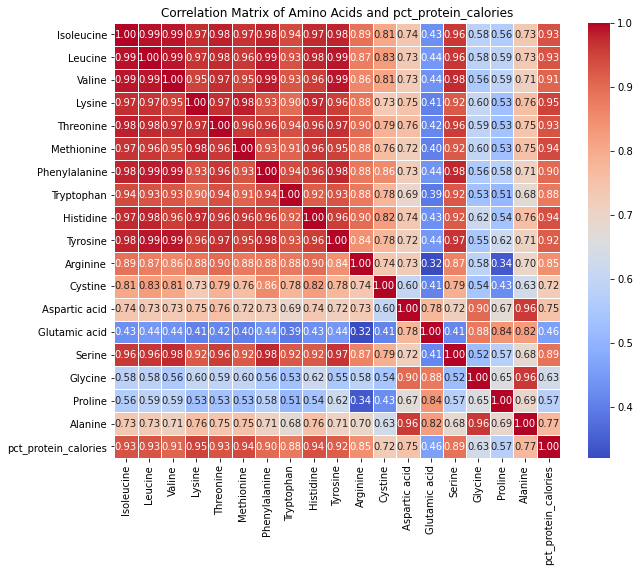

In [ ]:
# Define the subset of features: specific amino acid names + "pct_protein_calories"
amino_acids = [
    "Isoleucine", "Leucine", "Valine", "Lysine", "Threonine", "Methionine",
    "Phenylalanine", "Tryptophan", "Histidine", "Tyrosine", "Arginine",
    "Cystine",  # Corrected from Cysteine
    "Aspartic acid",  # Covers both Asparagine and Aspartate
    "Glutamic acid",  # Covers both Glutamine and Glutamate
    "Serine", "Glycine", "Proline", "Alanine"
]
subset_features = amino_acids + ["pct_protein_calories"]

# Extract the correlations for the subset of features
subset_corr = corr_matrix.loc[subset_features, subset_features]

# Display the correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(subset_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Amino Acids and pct_protein_calories")
plt.show()


### Analyzing gender VS energy and energy_Std

In [ ]:
# Compute the correlation matrix for the specified columns
corr_matrix_selected = diet_mb[["gender", "Energy", "Energy_std", "Energy Expenditure / Consumption Ratio"]].corr()

# Display the correlation matrix
print(corr_matrix_selected)

                                          gender    Energy  Energy_std  \
gender                                  1.000000  0.412942    0.309247   
Energy                                  0.412942  1.000000    0.532088   
Energy_std                              0.309247  0.532088    1.000000   
Energy Expenditure / Consumption Ratio  0.116594 -0.581680   -0.292104   

                                        Energy Expenditure / Consumption Ratio  
gender                                                                0.116594  
Energy                                                               -0.581680  
Energy_std                                                           -0.292104  
Energy Expenditure / Consumption Ratio                                1.000000  


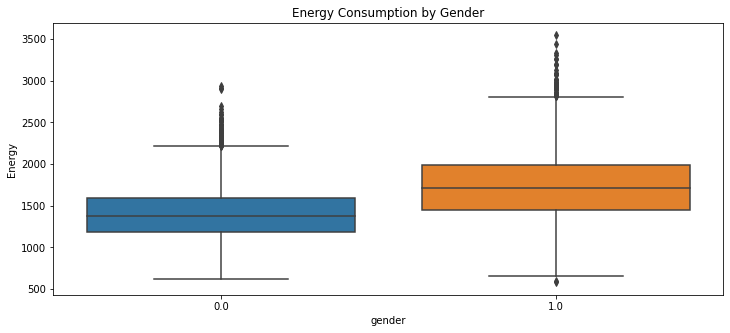

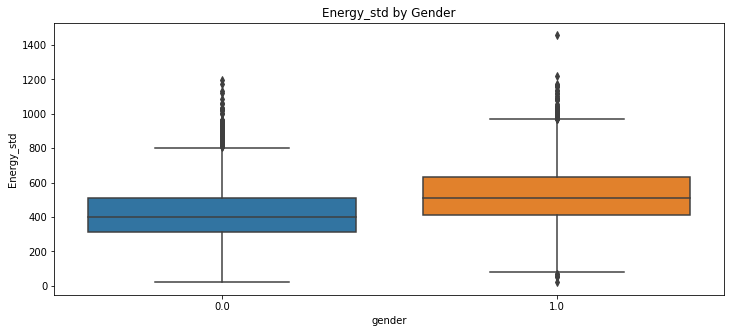

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))
sns.boxplot(x=diet_mb["gender"], y=diet_mb["Energy"])
plt.title("Energy Consumption by Gender")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x=diet_mb["gender"], y=diet_mb["Energy_std"])
plt.title("Energy_std by Gender")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Prepare data
X = diet_mb[["Energy", "Energy_std"]]
y = diet_mb["gender"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.69      0.77      0.73      1167
         1.0       0.68      0.58      0.63       985

    accuracy                           0.69      2152
   macro avg       0.69      0.68      0.68      2152
weighted avg       0.69      0.69      0.68      2152

Accuracy: 0.6858736059479554


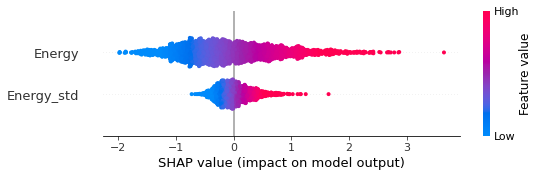

In [ ]:
import shap

# Use the previously trained model
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_test)

# Visualize SHAP values
shap.summary_plot(shap_values, X_test)


## Plotting the diet

In [ ]:
list(diet_mb.columns)

['Acorn squash',
 'Alfalfa sprouts',
 'Almond Beverage',
 'Almond flour',
 'Almond spread',
 'Almonds',
 'Amba',
 'Apple',
 'Apple Cake',
 'Apple Vinegar',
 'Apple juice',
 'Apricot',
 'Apropo',
 'Artichoke',
 'Arugula',
 'Asparagus',
 'Avocado',
 'Avocado Sandwich',
 'Bagel',
 'Baguette',
 'Baked apple',
 'Baklava',
 'Balsamic vinegar',
 'Bamba',
 'Banana',
 'Banana Cake',
 'Barbecue sauce',
 'Barley soup',
 'Basil',
 'Bean Noodles',
 'Bean soup',
 'Beans',
 'Beans black-eyed peas',
 'Beef',
 'Beef Cholent',
 'Beef Lasagna',
 'Beef Shawarma',
 'Beer',
 'Beet',
 'Beet Salad',
 'Berries',
 'Biscuit',
 'Bissli',
 'Black beans',
 'Blintzes',
 'Blue Cheese',
 'Blueberries',
 'Boiled corn',
 'Bolognese',
 'Bounty',
 'Brazil nuts',
 'Bread',
 'Bread Crumbs',
 'Brioche',
 'Broccoli',
 'Broth',
 'Brown Rice',
 'Brown Sugar',
 'Brownies',
 'Buckwheat Bread',
 'Buckwheat crackers',
 'Bulgur',
 'Burekas',
 'Butter',
 'Butter Cookies',
 'Caesar Salad',
 'Cake',
 'Calamari',
 'Camembert or Brie',
 

In [66]:
category_cols = ['AlcoholicDrinks',
 'Beefveallambandothermeatproducts',
 'Bread_cat',
 'Bread_wholewheat',
 'Cannedvegandfruits',
 'Cereals_cat',
 'Deepfriedfoods',
 'Drinks',
 'Eggsandtheirproducts',
 'FastFoods',
 'Fishandseafood',
 'Fruits',
 'Hardcheese',
 'Industrializedvegetarianfoodreadytoeat',
 'Lowcaloriesanddietdrinks',
 'MedOilandfats',
 'Nutsseedsandproducts',
 'Oilsandfats',
 'Others',
 'PastaGrainsandSidedishes',
 'PastaGrainsandSidedishes_wholewheat',
 'Poultryanditsproducts',
 'Proccessedmeatproducts',
 'Pulsesandproducts',
 'Snacks',
 'Soupsandsauces',
 'Spicesandherbs',
 'Vegetables',
 'bakedgoods',
 'fruitjuicesandsoftdrinks',
 'milkcreamcheeseandyogurts',
 'sweetmilkproducts',
 'sweets',]

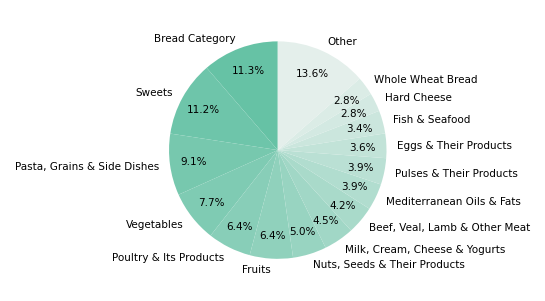

In [84]:
# Calculating the mean for each food column
# food_shortnames = food_shortnames.drop('Water')
diet_means = diet_by_person[category_cols].mean().sort_values(ascending=False)

def choose_top(diet_means, top_n=15):
    # Take top N and aggregate the remainder into "Other", then convert to %
    diet_means = diet_means.sort_values(ascending=False)
    top = diet_means.head(top_n)
    other_sum = diet_means.iloc[top_n:].sum()
    if other_sum > 0:
        combined = pd.concat([top, pd.Series({'Other': other_sum})])
    else:
        combined = top
    combined = combined / diet_means.sum() * 100
    
    # Rename categories using diet_rename_dict (if available), keep "Other" unchanged
    combined.index = [diet_rename_dict.get(idx, idx) if idx != "Other" else "Other" for idx in combined.index]
    
    return combined

# Creating the pie chart with smaller font sizes for better readability
def diet_pie(diet_means, title):
    diet_means = choose_top(diet_means)

    # Use seaborn Set2 palette
    # colors = sns.color_palette("Set2", n_colors=len(diet_means))
    cmap = sns.light_palette(palette[0], as_cmap=True, reverse=True)
    norm = Normalize(vmin=0, vmax=len(diet_means))
    colors = [cmap(norm(i)) for i in range(len(diet_means))]
    
    plt.style.use(single_style)
    plt.figure(facecolor='white')
    wedges, texts, autotexts = plt.pie(
        diet_means,
        labels=diet_means.index,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 5}, 
        colors=colors, 
    )
    # Adjust percentage font size and move it outward
    for autotext in autotexts:
        autotext.set_size(5)  # Smaller percentage font size
        autotext.set_position((1.3 * autotext.get_position()[0], 1.3 * autotext.get_position()[1]))
    plt.savefig(f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/figures/{title}_categories.png", dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
    plt.savefig(f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/figures/{title}_categories.pdf", dpi=400, facecolor="white", transparent=False, bbox_inches='tight', format='pdf')
    plt.show()

diet_pie(diet_means, "All_Foods")


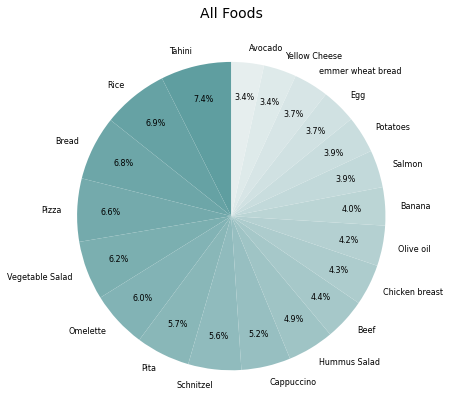

In [63]:
if show:
    # Calculating the mean for each food column
    # food_shortnames = food_shortnames.drop('Water')
    diet_means = diet_by_person[food_shortnames].mean().sort_values(ascending=False)

    def choose_top(diet_means):
        # Aggregating the top 10 contributors and combining the rest into "Other"
        top_diet = diet_means.head(20)
        top_diet = top_diet / top_diet.sum() * 100
        return top_diet


    # Creating the pie chart with smaller font sizes for better readability
    def diet_pie(diet_means, title):
        diet_means = choose_top(diet_means)

        cmap = sns.light_palette("cadetblue", as_cmap=True, reverse=True)
        norm = Normalize(vmin=0, vmax=len(diet_means))
        colors = [cmap(norm(i)) for i in range(len(diet_means))]
        
        plt.figure(figsize=(7.09, 7.09), facecolor='white')
        wedges, texts, autotexts = plt.pie(
            diet_means,
            labels=diet_means.index,
            autopct='%1.1f%%',
            startangle=90,
            textprops={'fontsize': 8}, 
            colors=colors, 
        )
        # Adjust percentage font size and move it outward
        for autotext in autotexts:
            autotext.set_size(8)  # Smaller percentage font size
            autotext.set_position((1.3 * autotext.get_position()[0], 1.3 * autotext.get_position()[1]))
        plt.title(title, fontsize=14, color='black')
        plt.savefig(f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/figures/{title}_foods.png", dpi=300, facecolor="white", transparent=False, bbox_inches='tight')
        plt.show()

    diet_pie(diet_means, "All Foods")

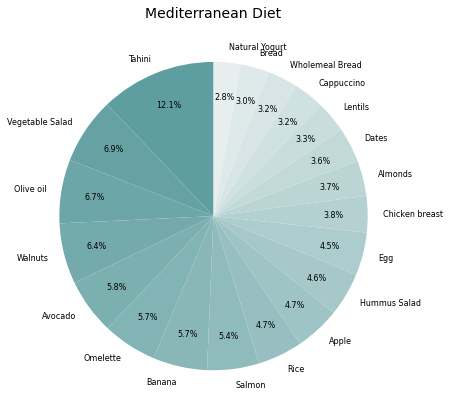

In [ ]:
def plot_foods_of_diet(diet_score, diet_name):
    # Subset diet_by_person to people above the 90th percentile of med_diet_adherence_score.
    # Then call diet_pie on the subset.
    # Subset diet_by_person to people above the 90th percentile of 'med_diet_adherence_score'
    threshold = diet_by_person[diet_score].quantile(0.9)
    subset = diet_by_person[diet_by_person[diet_score] > threshold]

    # Calculate the mean diet distribution for the subset
    subset_means = subset[food_shortnames].mean().sort_values(ascending=False)
    diet_pie(subset_means, f"{diet_name}")

if show:
    plot_foods_of_diet("med_score_per_day", "Mediterranean Diet")

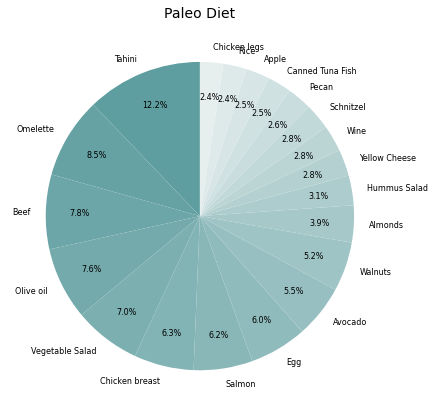

In [ ]:
if show:
    plot_foods_of_diet("paleo_score_per_day", "Paleo Diet")

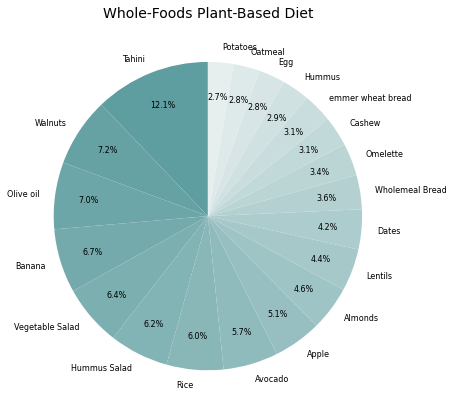

In [ ]:
if show:
    plot_foods_of_diet("wfpb_score_per_day", "Whole-Foods Plant-Based Diet")

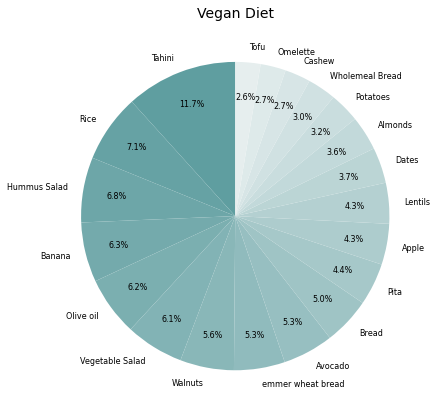

In [ ]:
if show:
    plot_foods_of_diet("vegan_score_per_day", "Vegan Diet")

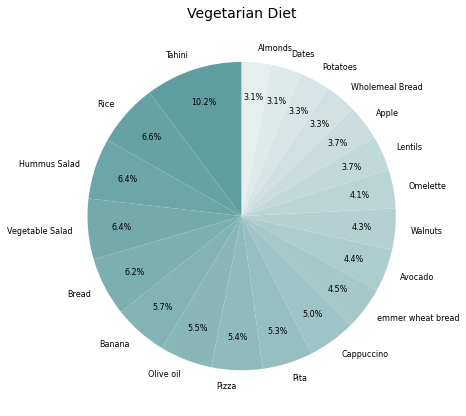

In [ ]:
if show:   
    plot_foods_of_diet("vegetarian_score_per_day", "Vegetarian Diet")

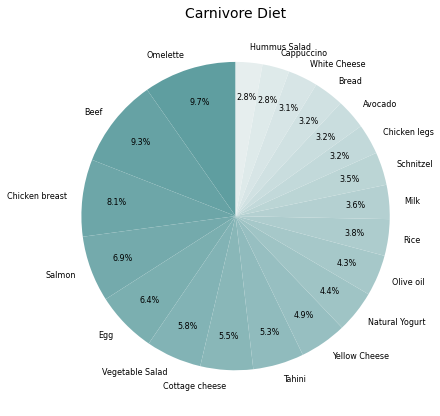

In [ ]:
if show:
    plot_foods_of_diet("carnivore_score_per_day", "Carnivore Diet")

In [ ]:
if stage == '02_00_visit':
    # Convert diet_mb.columns to a set for comparison
    diet_mb_columns = set(diet_mb.columns)

    # Find differences
    only_in_all_diet_features = set(all_diet_features) - diet_mb_columns
    only_in_diet_mb_columns = diet_mb_columns - set(all_diet_features)

    # Check if there is a mismatch and show the different items
    if only_in_all_diet_features or only_in_diet_mb_columns:
        print("Mismatch between all_diet_features and diet_mb.columns.")
        if only_in_all_diet_features:
            print("Items only in all_diet_features:", only_in_all_diet_features)
        if only_in_diet_mb_columns:
            print("Items only in diet_mb.columns:", only_in_diet_mb_columns)
    else:
        print("Validation successful: all_diet_features contains the same items as diet_mb.columns.")


In [ ]:
all_diet_features = list(diet_mb.columns)
len(all_diet_features)

720

In [ ]:
# diet_corr = diet_mb[all_diet_features].corr()

# high_corr_pairs = diet_corr[(np.abs(diet_corr) > 0.9)]

# # Step 3: Unstack and filter to get pairs of features with correlation > 0.8
# high_corr_pairs = high_corr_pairs.unstack().dropna()

# # Since the matrix is symmetric, we need to filter out duplicates
# high_corr_pairs = high_corr_pairs[high_corr_pairs.index.get_level_values(0) < high_corr_pairs.index.get_level_values(1)]

# # Display the high correlation pairs
# pd.set_option('display.max_rows', None)
# high_corr_pairs

In [ ]:
pd.reset_option('display.max_rows')

In [ ]:
log_day_with_gender = log_day.reset_index().merge(subjects_df[["gender"]], on="RegistrationCode").set_index(["RegistrationCode", "Day"])
log_day_with_gender

Protein  Total lipid (fat)  \
RegistrationCode Day                                       
10K_1000942861   2021-12-13  0.041705           0.043752   
                 2021-12-14  0.054377           0.037942   
                 2021-12-15  0.044103           0.046787   
                 2021-12-16  0.040880           0.032585   
                 2021-12-17  0.067031           0.051445   
...                               ...                ...   
10K_9999409119   2020-06-18  0.028867           0.028560   
                 2020-06-19  0.040723           0.053118   
                 2020-06-20  0.027381           0.051569   
                 2020-06-21  0.026922           0.037323   
                 2020-06-22  0.026869           0.041204   

                             Carbohydrate, by difference       Energy  \
RegistrationCode Day                                                    
10K_1000942861   2021-12-13                     0.116179  2320.424974   
                 2021-12-14                     0.111940  1407.229165   
                 2021-12-15                     0.101961  1548.049988   
                 2021-12-16                     0.124630  1773.616661   
                 2021-12-17                     0.067963  2458.909988   
...                                                  ...          ...   
10K_9999409119   2020-06-18                     0.169896   910.237320   
                 2020-06-19                     0.104063  1419.590000   
                 2020-06-20                     0.093900  1434.397500   
                 2020-06-21                     0.145461  2164.896633   
                 2020-06-22                     0.143699   761.235001   

                             Alcohol, ethyl     Water  Fiber, total dietary  \
RegistrationCode Day                                                          
10K_1000942861   2021-12-13        0.000000  0.384561              0.013180   
                 2021-12-14        0.000000  0.911721              0.019116   
                 2021-12-15        0.000000  0.292562              0.010944   
                 2021-12-16        0.007823  0.464286              0.005461   
                 2021-12-17        0.000000  0.239666              0.005249   
...                                     ...       ...                   ...   
10K_9999409119   2020-06-18        0.000000  1.545518              0.016074   
                 2020-06-19        0.000000  0.737657              0.015233   
                 2020-06-20        0.016000  0.824900              0.018308   
                 2020-06-21        0.000000  0.496270              0.017387   
                 2020-06-22        0.000000  0.497829              0.022693   

                             Calcium, Ca  Iron, Fe  Magnesium, Mg  \
RegistrationCode Day                                                
10K_1000942861   2021-12-13     0.390019  0.007656       0.168797   
                 2021-12-14     0.292952  0.006843       0.179026   
                 2021-12-15     0.191529  0.005626       0.143003   
                 2021-12-16     0.304803  0.006467       0.112339   
                 2021-12-17     0.101939  0.007593       0.123936   
...                                  ...       ...            ...   
10K_9999409119   2020-06-18     0.516281  0.009829       0.316119   
                 2020-06-19     0.751463  0.011677       0.223336   
                 2020-06-20     0.462684  0.009057       0.236249   
                 2020-06-21     0.357304  0.007243       0.194410   
                 2020-06-22     0.296334  0.012504       0.336841   

                             Phosphorus, P  Potassium, K  Sodium, Na  \
RegistrationCode Day                                                   
10K_1000942861   2021-12-13       0.770525      1.048000    0.996108   
                 2021-12-14       0.676106      1.578893    1.719074   
                 2021-12-15       0.623402      1.445846    1.030858   
             

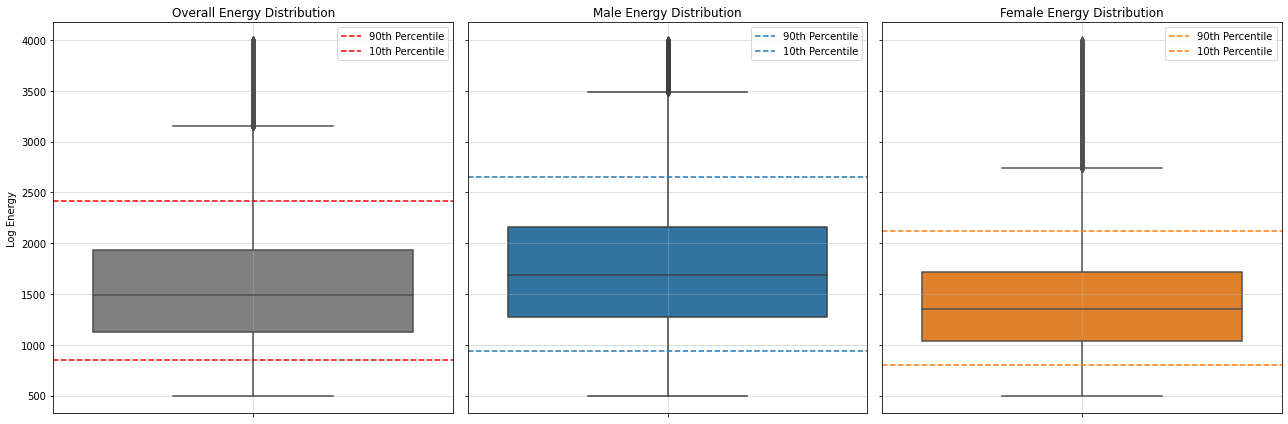

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a figure with three subplots (Overall, Male, Female)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Calculate percentiles
overall_90th = np.percentile(log_day_with_gender["Energy"], 90)
overall_10th = np.percentile(log_day_with_gender["Energy"], 10)
male_data = log_day_with_gender[log_day_with_gender["gender"] == 1]["Energy"]
female_data = log_day_with_gender[log_day_with_gender["gender"] == 0]["Energy"]

male_90th = np.percentile(male_data, 90)
male_10th = np.percentile(male_data, 10)
female_90th = np.percentile(female_data, 90)
female_10th = np.percentile(female_data, 10)

# Overall Boxplot
sns.boxplot(y=log_day_with_gender["Energy"], ax=axes[0], color="gray")
axes[0].set_title("Overall Energy Distribution")
axes[0].set_ylabel("Log Energy")
axes[0].axhline(overall_90th, color='red', linestyle='--', label='90th Percentile')
axes[0].axhline(overall_10th, color='red', linestyle='--', label='10th Percentile')

# Male Boxplot
sns.boxplot(y=male_data, ax=axes[1], color="tab:blue")
axes[1].set_title("Male Energy Distribution")
axes[1].set_ylabel("")
axes[1].axhline(male_90th, color='tab:blue', linestyle='--', label='90th Percentile')
axes[1].axhline(male_10th, color='tab:blue', linestyle='--', label='10th Percentile')

# Female Boxplot
sns.boxplot(y=female_data, ax=axes[2], color="tab:orange")
axes[2].set_title("Female Energy Distribution")
axes[2].set_ylabel("")
axes[2].axhline(female_90th, color='tab:orange', linestyle='--', label='90th Percentile')
axes[2].axhline(female_10th, color='tab:orange', linestyle='--', label='10th Percentile')

# Set legend only on the first subplot
axes[0].legend()
axes[1].legend()
axes[2].legend()

# Adjust layout and show plot
axes[0].grid(True, alpha=0.5)
axes[1].grid(True, alpha=0.5)
axes[2].grid(True, alpha=0.5)
plt.tight_layout()
plt.show()


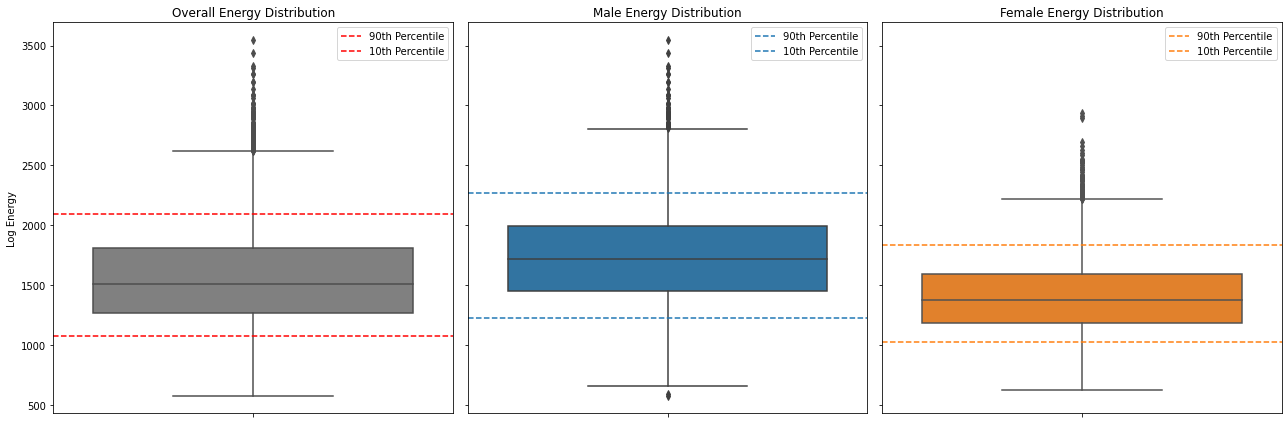

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a figure with three subplots (Overall, Male, Female)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Calculate percentiles
overall_90th = np.percentile(diet_mb["Energy"], 90)
overall_10th = np.percentile(diet_mb["Energy"], 10)
male_data = diet_mb[diet_mb["gender"] == 1]["Energy"]
female_data = diet_mb[diet_mb["gender"] == 0]["Energy"]

male_90th = np.percentile(male_data, 90)
male_10th = np.percentile(male_data, 10)
female_90th = np.percentile(female_data, 90)
female_10th = np.percentile(female_data, 10)

# Overall Boxplot
sns.boxplot(y=diet_mb["Energy"], ax=axes[0], color="gray")
axes[0].set_title("Overall Energy Distribution")
axes[0].set_ylabel("Log Energy")
axes[0].axhline(overall_90th, color='red', linestyle='--', label='90th Percentile')
axes[0].axhline(overall_10th, color='red', linestyle='--', label='10th Percentile')

# Male Boxplot
sns.boxplot(y=male_data, ax=axes[1], color="tab:blue")
axes[1].set_title("Male Energy Distribution")
axes[1].set_ylabel("")
axes[1].axhline(male_90th, color='tab:blue', linestyle='--', label='90th Percentile')
axes[1].axhline(male_10th, color='tab:blue', linestyle='--', label='10th Percentile')

# Female Boxplot
sns.boxplot(y=female_data, ax=axes[2], color="tab:orange")
axes[2].set_title("Female Energy Distribution")
axes[2].set_ylabel("")
axes[2].axhline(female_90th, color='tab:orange', linestyle='--', label='90th Percentile')
axes[2].axhline(female_10th, color='tab:orange', linestyle='--', label='10th Percentile')

# Set legend only on the first subplot
axes[0].legend()
axes[1].legend()
axes[2].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()
